The construction of the 10 convolutional kernals is very similar ro problem 5. The only difference is that instead of image number 5, I use image 0~9 for each kernel. In fact, I use exactly the same function I use in problem 5. 

In [53]:
from matplotlib.image import imread
X = []
for i in range(10):
    X.append(imread('data/'+str(i)+'.png'))
X = np.asarray(X)
img = imread('data/img.png')
H = img.shape[0]
W = img.shape[1]
#since img[i][j][0] == img[i][j][1] == img[i][j][2] for any i, j
# I just use the first color channel of img.png
img = img[:,:,0]
#normalize 10 images
for i in range(10):
    mean = np.sum(X[i])/(28*28)
    X[i] = X[i] - mean
    
#compute kernal
K = []
for i in range(10):
    K.append(kernel(X[i],28,H,W))
K = np.asarray(K)

# The following matrix takes me at least 15 minutes to compute, so I save it to local file
# #compute C(h), i.e, A, for each kernel
# C = []
# for i in range(10):
#     print(i)
#     c = Convolve2(K[i])
#     C.append(cut2(c,28,H+28,W+28))
# C = np.asarray(C)
#np.save('../../../../Downloads/conv',C)

In [ ]:
# Load matrix C
C = np.load('../../../../Downloads/conv')

img = imread('data/img.png')
img = img[:,:,0]
print(img.shape)
#compute alpha
alpha = []
for i in range(10):
    alpha.append((C[i].dot(img.reshape(H*W,1))).reshape(H,W))
alpha = np.asarray(alpha)
np.save('../../../../Downloads/alpha',alpha)

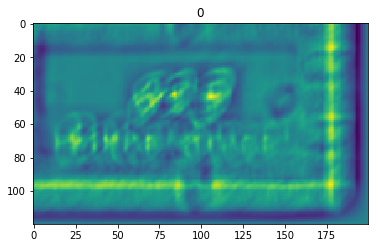

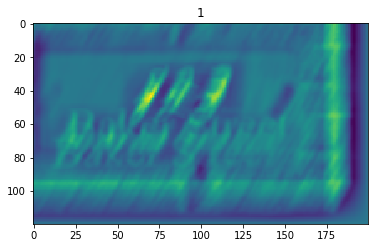

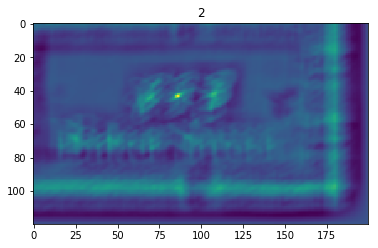

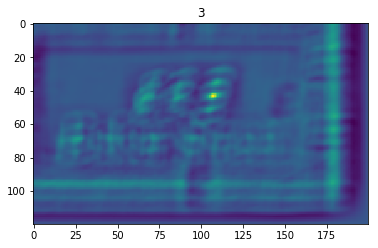

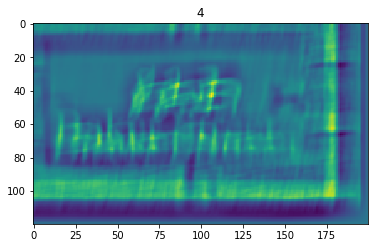

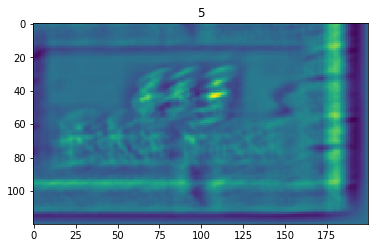

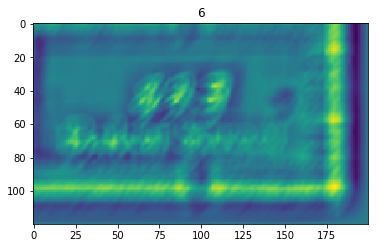

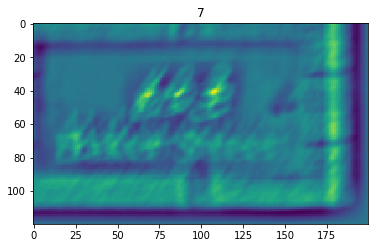

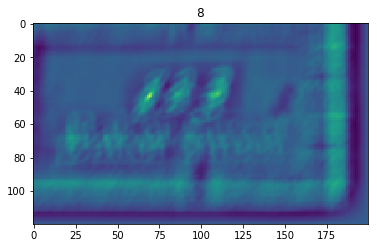

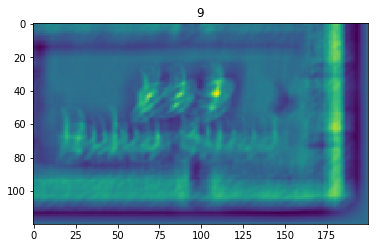

In [54]:
alpha = np.load('../../../../Downloads/alpha.npy')
for i in range(10):
    plt.imshow(alpha[i])
    plt.title(str(i))
    plt.savefig(str(i)+'.png')
    plt.show()

Plot of 10 maximal values

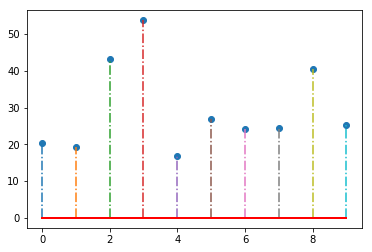

In [55]:
max_val = np.zeros((10,))
for i in range(10):
    max_val[i] = np.max(alpha[i])
x = np.arange(10)
markerline, stemlines, baseline = plt.stem(x, max_val, '-.')
plt.setp(baseline, color='r', linewidth=2)
plt.show()

In [65]:
#By visual inspection
T = 40
beta = []
above = []
for i in range(10):
    b = np.zeros((H,W))
    for h in range(H):
        for w in range(W):
            if alpha[i][h][w] > T:
                b[h,w] = alpha[i,h,w]
                above.append([i,b[h,w],h,w])
    beta.append(b)
print(above)
print(beta[i].shape)

[[2, 43.28044932029071, 43, 86], [3, 41.25695040424196, 42, 107], [3, 46.175210898284774, 43, 106], [3, 53.74879325378484, 43, 107], [3, 46.10347510251782, 43, 108], [8, 40.53257279246146, 43, 69]]
(120, 200)


Stem plot of the global max-pooled values (T=40). And bounding box. <br>
One thing to notice here is that after thresholding, number 3 kernel's feature map exists four non zero values at location (42,107),(43,106),(43,107),(43,108). Thus locations are 1 pixel close to each other and have very high values. And, I cannot make threshold any higher, since it will cut out number 2 and 8. 

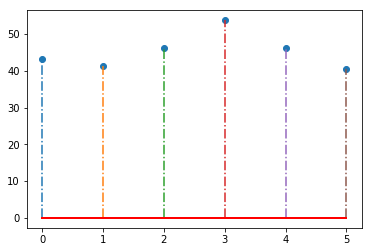

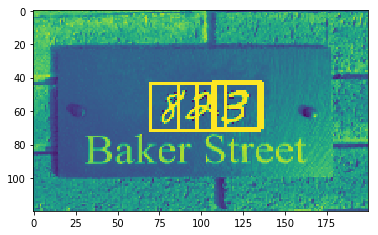

In [57]:
#This function draw white bounding box in image, where s = line width
def draw_box (img,x,y,h,w,s):
    l = np.max(img)
    img[x:(x+s),y:(y+w)] = l
    img[(x+h):(x+h+s),y:(y+w)] = l
    img[x:(x+h),y:(y+s)] = l
    img[x:(x+h),(y+w):(y+w+s)] = l
    return img

#max-pooled values
x = np.arange(len(above))
max_pool = np.zeros((len(above),))
for i in range(max_pool.shape[0]):
    max_pool[i] = above[i][1]
markerline, stemlines, baseline = plt.stem(x, max_pool, '-.')
plt.setp(baseline, color='r', linewidth=2)
plt.show()

#bounding box
img_d = img.copy()
for i in above:
    img_d = draw_box(img_d,i[2],i[3],28,28,2)
plt.imshow(img_d)
plt.savefig('bounding box.png')

Similar to problem 5c, to construct, we just C.T.dot(Thresholded feature map beta). Following cell output is a plot $ y[n1][n2]$.

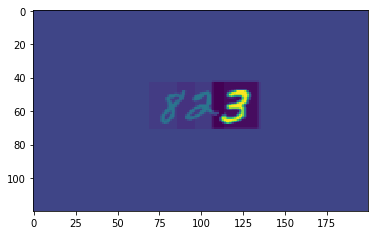

In [69]:
# C = np.load('../../../../Downloads/conv.npy')
# decode digits
img = imread('data/img.png')
H = img.shape[0]
W = img.shape[1]

digits = np.zeros((H*W,1))
for i in range(10):
    Decode = C[i].T
    d = Decode.dot(beta[i].reshape(H*W,1))
    digits = digits + d
plt.imshow(digits.reshape(H,W))

Plot of reconstrcuted image. <br>
The reason there are black regions aroung the digits is that, in part a, after substracting the mean, each digit's kernel has negative value all around it.  

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


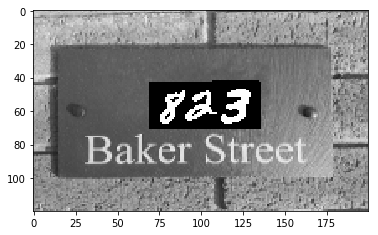

In [70]:
# add decoded digits to background.png
back = imread('data/background.png')
plt.show()
for i in range(3):
    back[:,:,i] = back[:,:,i] + digits.reshape(H,W)
plt.imshow(back)
plt.savefig('reconstruct.png')
plt.show()

Given that the distance between the three digits are 17 and 21. The first 2d layer of kernal detects top left corner of the first digit. And second 2d layer of the kernel detects top left corner of second digit, and the third 2d layer of the kernel detects top left corner of third digit. And let it convolve any combination of three alpha_i out of the 10. Then, we choose the feature map as the one that contains maximal value. Then we max_pool the feature map. To get the location of top left corner of the first digit. Then, we can just draw the bounding box. 

In [ ]:
import numpy as np
alpha = np.load('../../../../Downloads/alpha.npy')
print(alpha.shape)
H = alpha.shape[1]
W = alpha.shape[2]
#construct kernel in a row version for quick runtime
kernal = np.zeros((3,120,200))
kernal[0,:,0] = 1
kernal[1,:,17] = 1
kernal[2,:,38] = 1

#define a function that convolve the kernel 3d on the any 3 alpha
def conv (k,a_1,a_2,a_3):
    beta = np.empty((H,W))
    for i in range(W):
        k_n = np.zeros((k.shape[0],k.shape[1],k.shape[2]))
        k_n[0,:,i] = 1
        if (i+17) < W:
            k_n[1,:,i+17] = 1
        if (i+38) < W:
            k_n[2,:,i+38] = 1
        beta[:,i] = np.sum(np.sum((k_n * np.array([a_1,a_2,a_3])),axis=0),axis=1)
    return beta

#find all possible combination
pi = []
for i in range(10):
    for j in range(10):
        for k in range(10):
            pi.append(np.array([i,j,k]))
pi = np.asarray(pi)
print(pi.shape)
pi = np.unique(pi,axis=0)
index = []
for i in range(pi.shape[0]):
    p = pi[i]
    if ( (p[0]==p[1]) or (p[0]==p[2]) or (p[1]==p[2]) ):
        index.append(i)
pi = np.delete(pi,index,0)
print(pi.shape)

#possible feature maps
Beta = []
max_v = []
print(kernal.shape)
for i in pi:
    beta = conv (kernal,alpha[i[0]],alpha[i[1]],alpha[i[2]])
    Beta.append(beta)
    max_v.append(np.max(beta))

The sequence is [8 2 3]


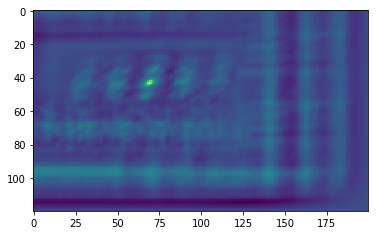

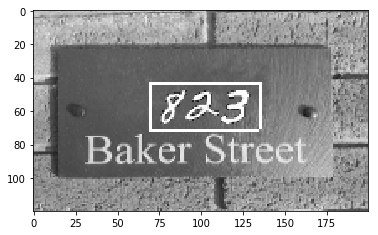

In [73]:
import matplotlib.pyplot as plt
import matplotlib.image as img
from matplotlib.image import imread

#find the most fit feature map
best = np.argmax(max_v)
print("The sequence is "+str(pi[best]))

#Plot the most fit feature map
plt.imshow(Beta[best])
plt.show()

# Find the location of the top left corner of bounding 
def draw_box (img,x,y,h,w,s):
    l = np.max(img)
    img[x:(x+s),y:(y+w)] = l
    img[(x+h):(x+h+s),y:(y+w)] = l
    img[x:(x+h),y:(y+s)] = l
    img[x:(x+h),(y+w):(y+w+s)] = l
    return img

img = imread('data/img.png')
img = draw_box(img,loc2D[0],loc2D[1],28,38+28,2)
plt.imshow(img)
plt.show()